In [1]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from mlforecast import MLForecast

from xgboost import XGBRegressor

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from src.evaluation.evaluation import MetricEvaluator

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [3]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [4]:
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

lags = [1,2,3,4,5,6,7,8,9,10,11,12]

evaluator = MetricEvaluator()

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


### Raw

In [5]:
model = make_pipeline(
    MinMaxScaler(feature_range=(0, 1)),
    XGBRegressor(
        n_estimators=50, 
        learning_rate=0.03125,
        reg_alpha=0, 
        reg_lambda=0.01,
        max_depth=6, 
        objective='reg:squarederror'
    )
)

fcst = MLForecast(
    models={'xgb': model},
    lags=lags,
    freq='MS'
)

In [6]:
fcst.fit(full_train)

MLForecast(models=[xgb], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [7]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [8]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [9]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['xgb'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations         MAE      MAPE           MSE  \
0    ACUCAR_SANTOS   xgb              20   13.704857  0.093938    260.615709   
1        ACUCAR_SP   xgb             100   17.848643  0.214545    375.393230   
2          ALGODAO   xgb             205   23.836150  0.060898   1382.868360   
3            ARROZ   xgb             277   29.405361  0.613783    888.740308   
4     CAFE_ARABICA   xgb             381  130.231368  0.157442  77182.657156   
5     CAFE_ROBUSTA   xgb             468   38.720097  0.043639  24324.949224   
6            MILHO   xgb             543   31.678531  0.764398   1013.710844   
7      SOJA_PARANA   xgb             644   26.521350  0.363085    735.843617   
8   SOJA_PARANAGUA   xgb             714   16.291092  0.187121    273.361494   
9     TRIGO_PARANA   xgb             791  233.794205  0.239254  84525.356420   
10        TRIGO_RS   xgb             868  183.509268  0.202161  57856.050997   

          RMSE        R2  
0    16.1435

In [10]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                         MAPE                  \
          mean      std      min       max   median    mean     std     min   
Model                                                                         
xgb    67.7764  77.5734  13.7049  233.7942  29.4054  0.2673  0.2292  0.0436   

                              MSE                                    \
          max  median        mean         std       min         max   
Model                                                                 
xgb    0.7644  0.2022  22619.9589  33789.0384  260.6157  84525.3564   

                      RMSE                                            R2  \
          median      mean       std      min       max   median    mean   
Model                                                                      
xgb    1013.7108  103.9149  114.0343  16.1436  290.7324  31.8388 -0.6844   

                                       
          std     min   

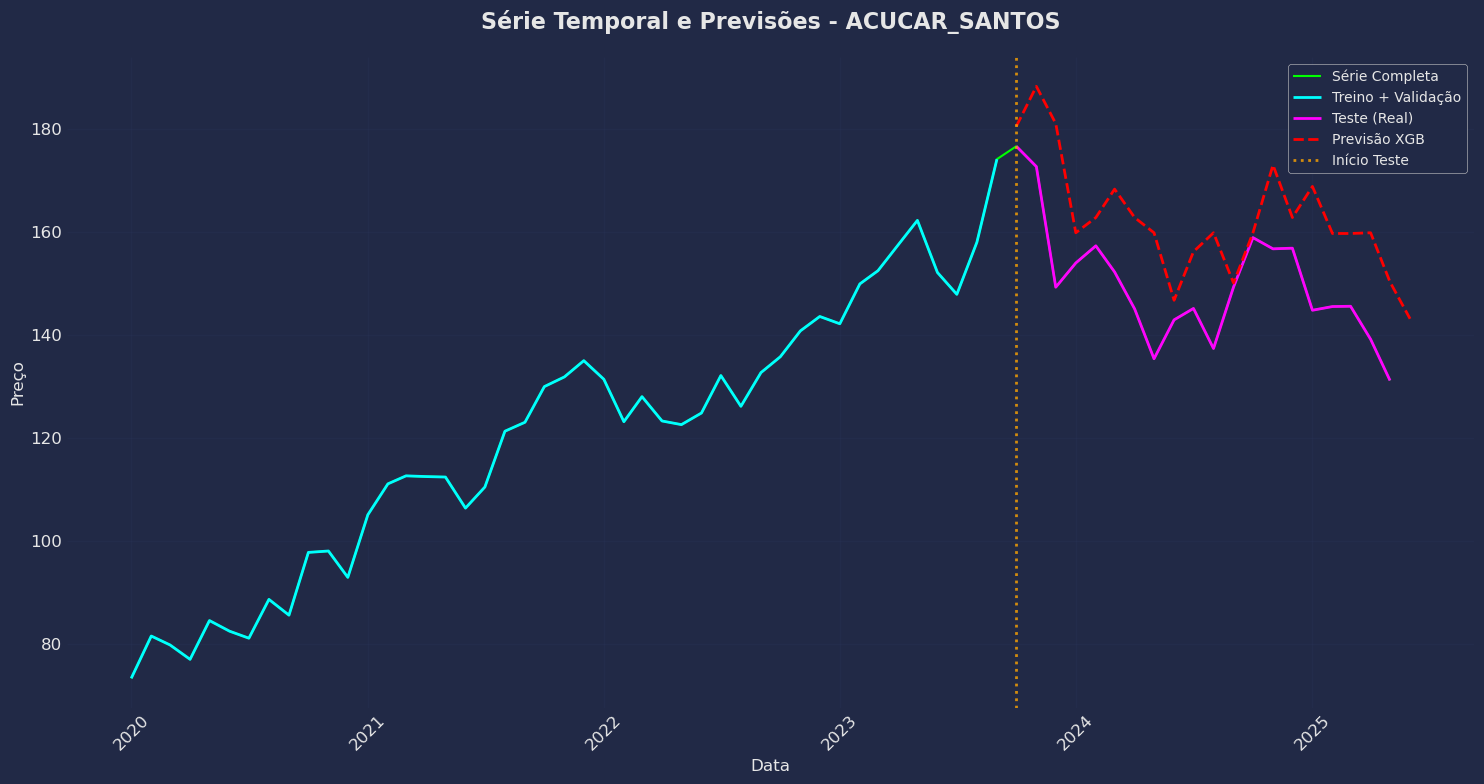

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


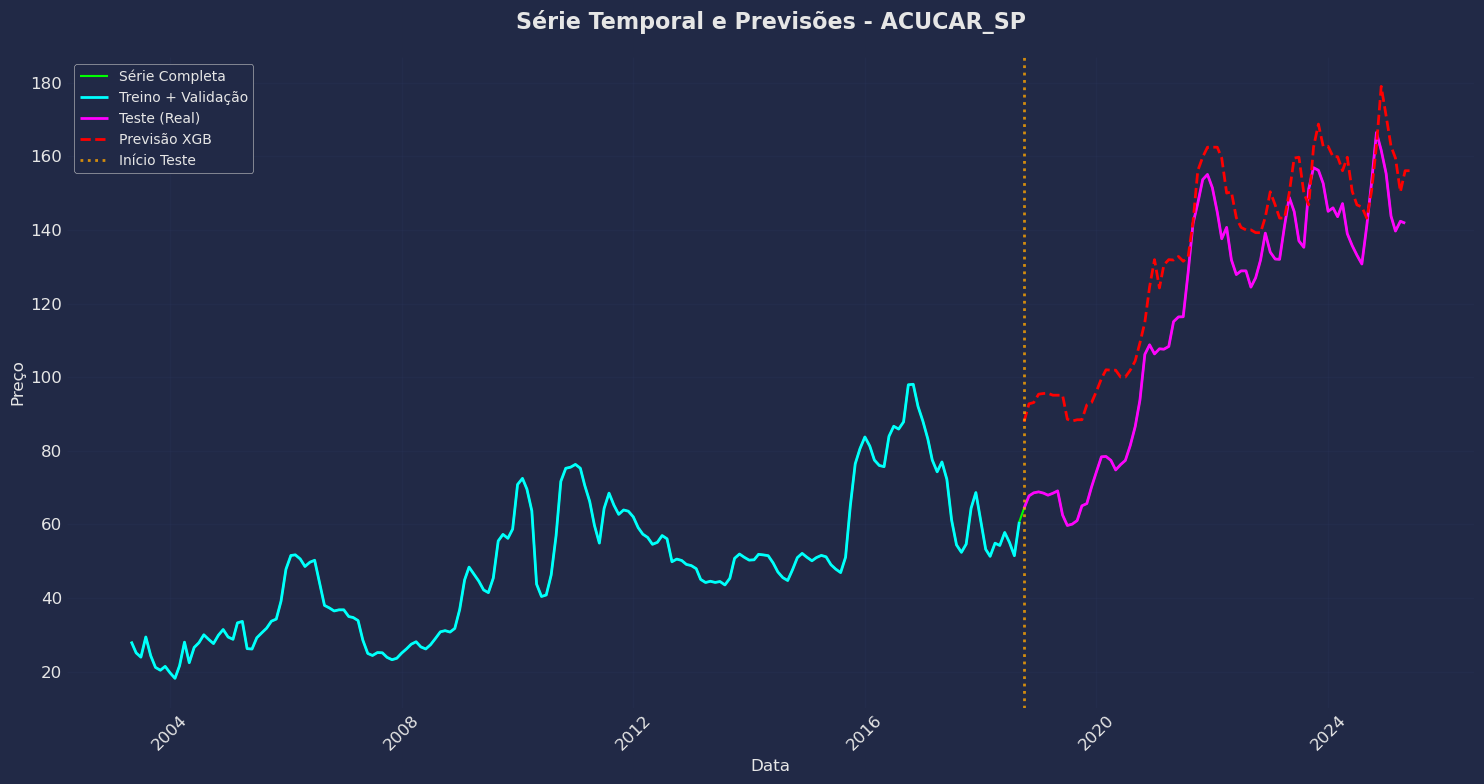

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


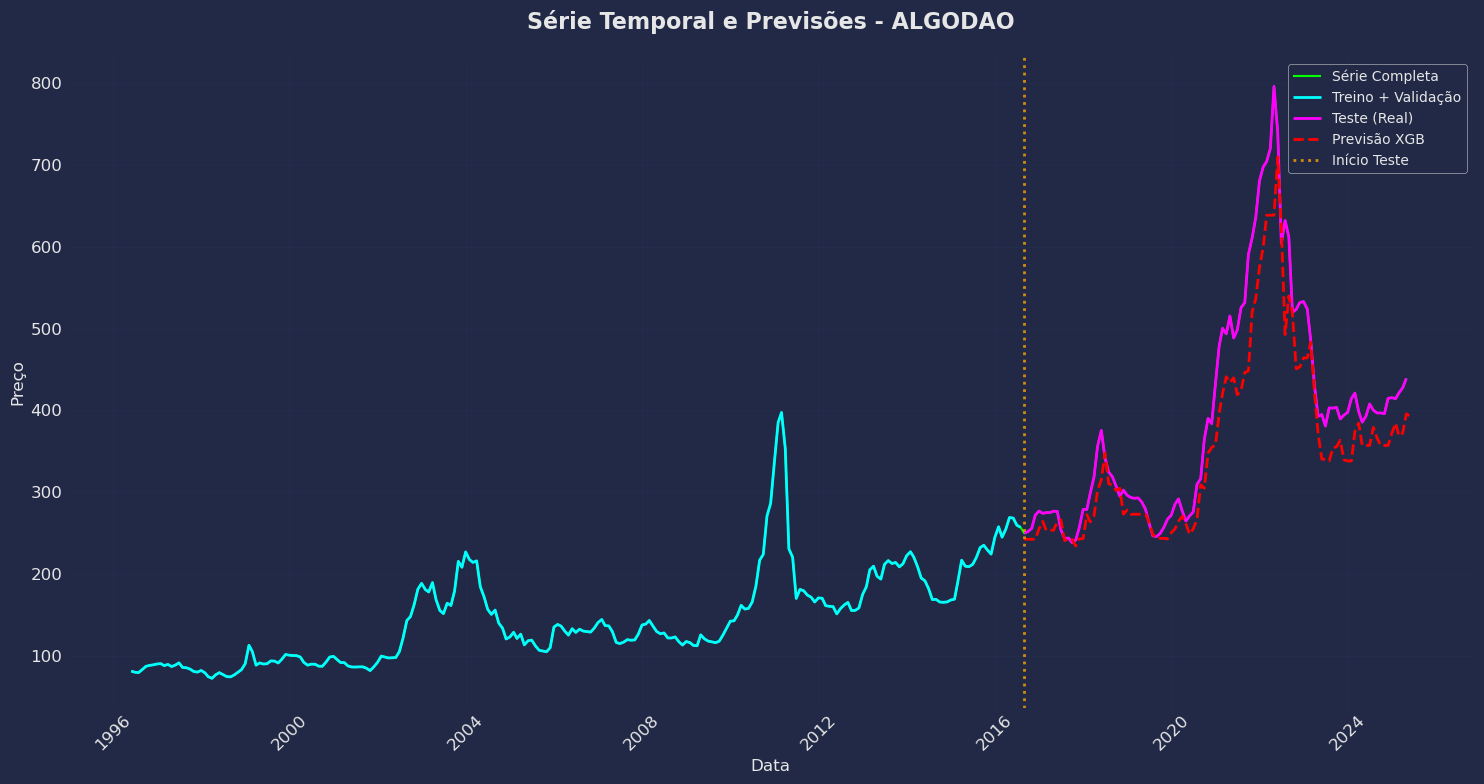

Gráfico exibido para: ALGODAO
--------------------------------------------------


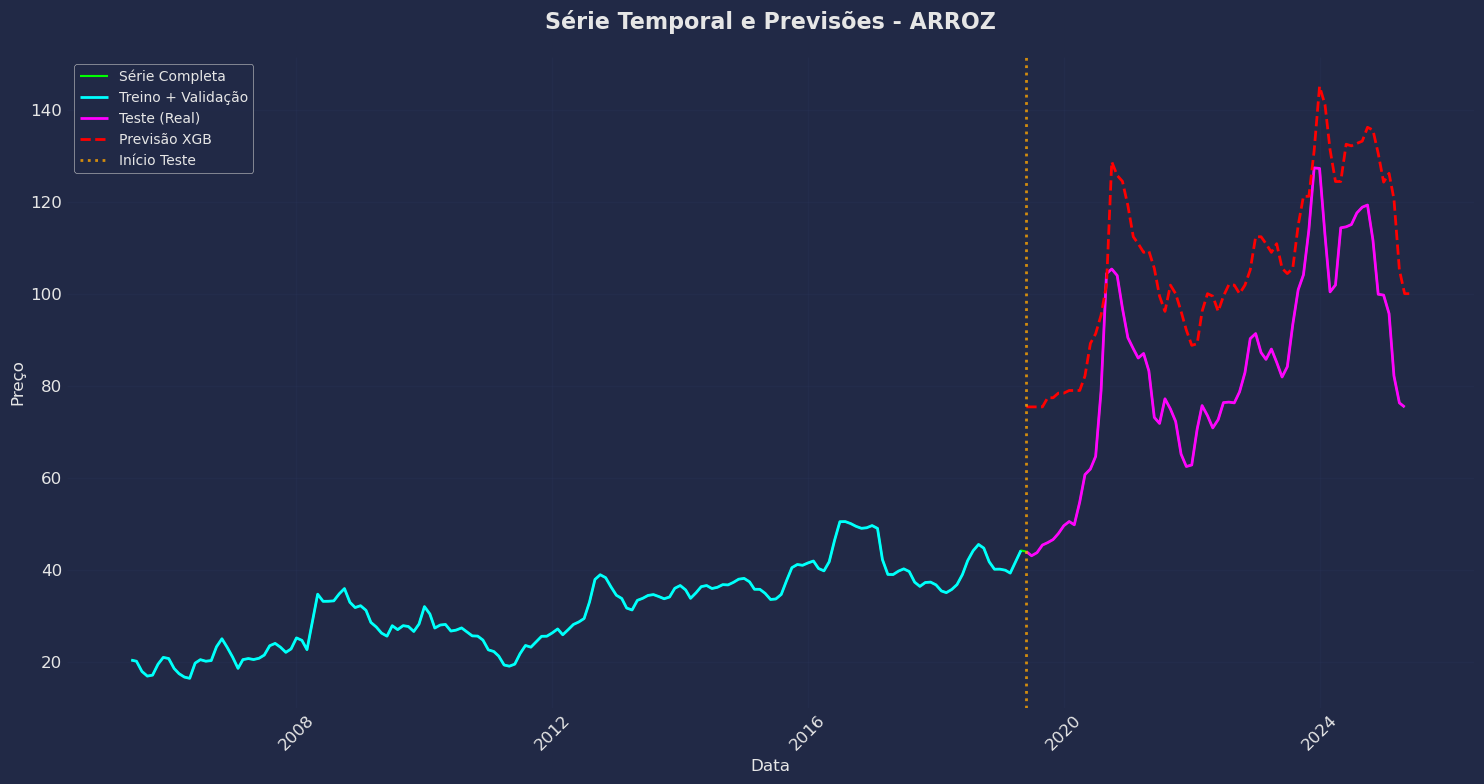

Gráfico exibido para: ARROZ
--------------------------------------------------


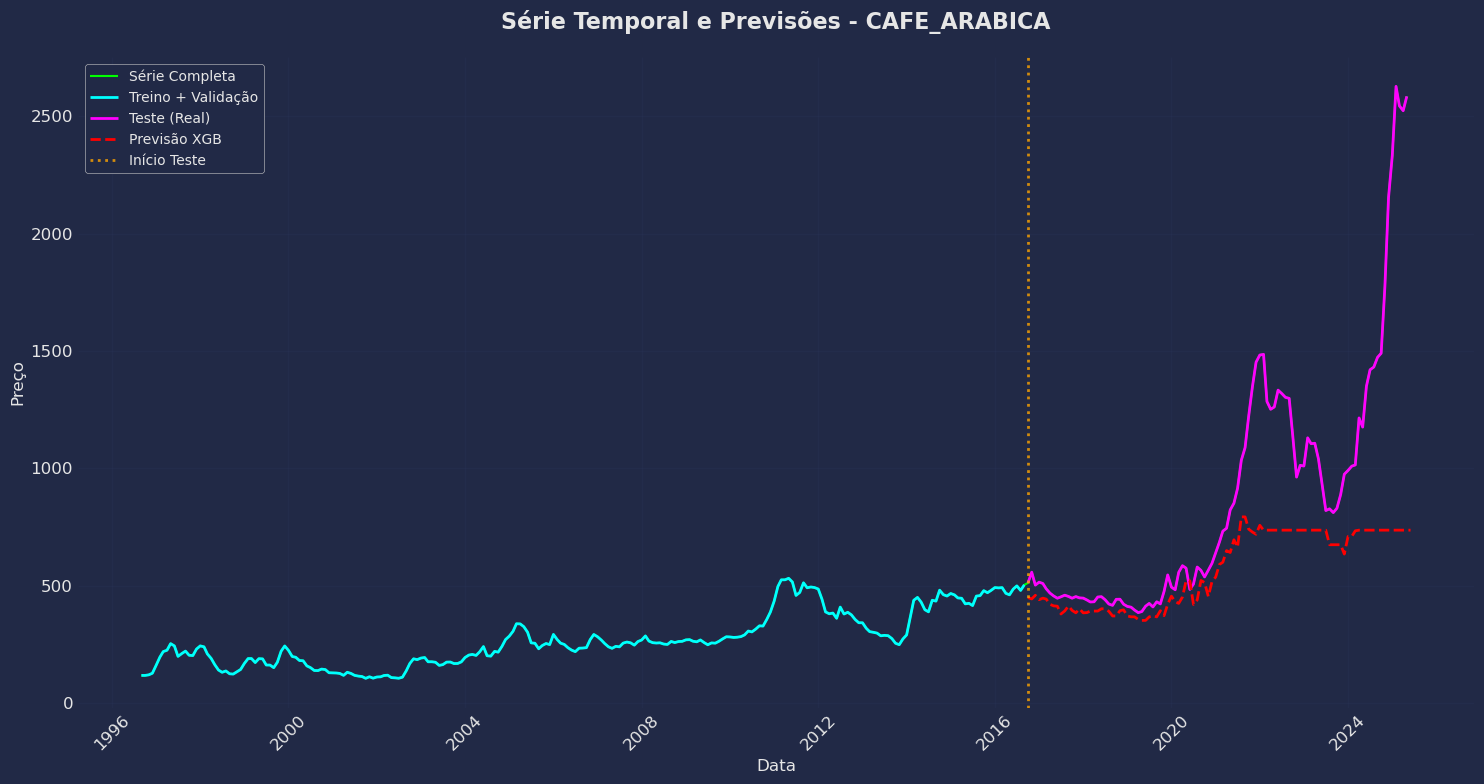

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


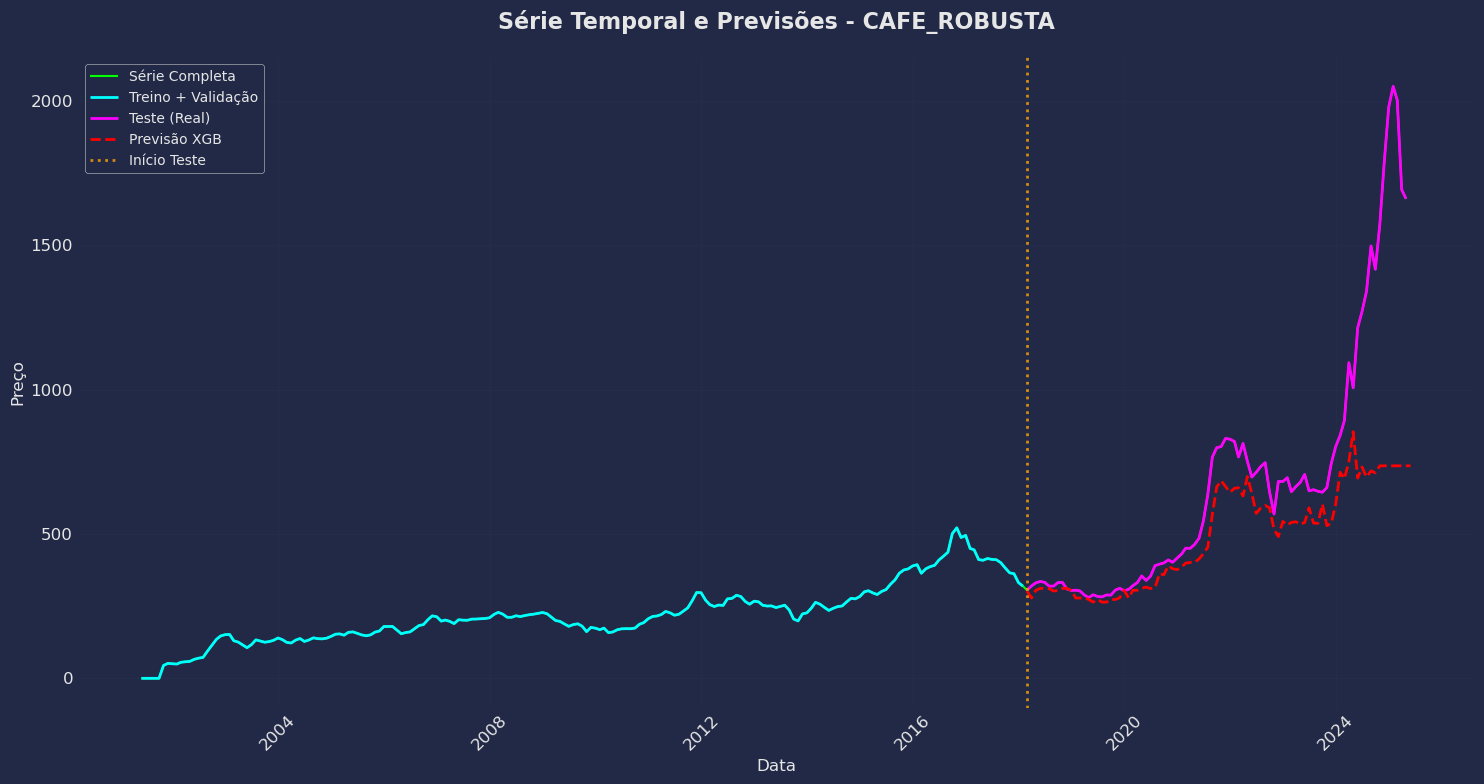

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


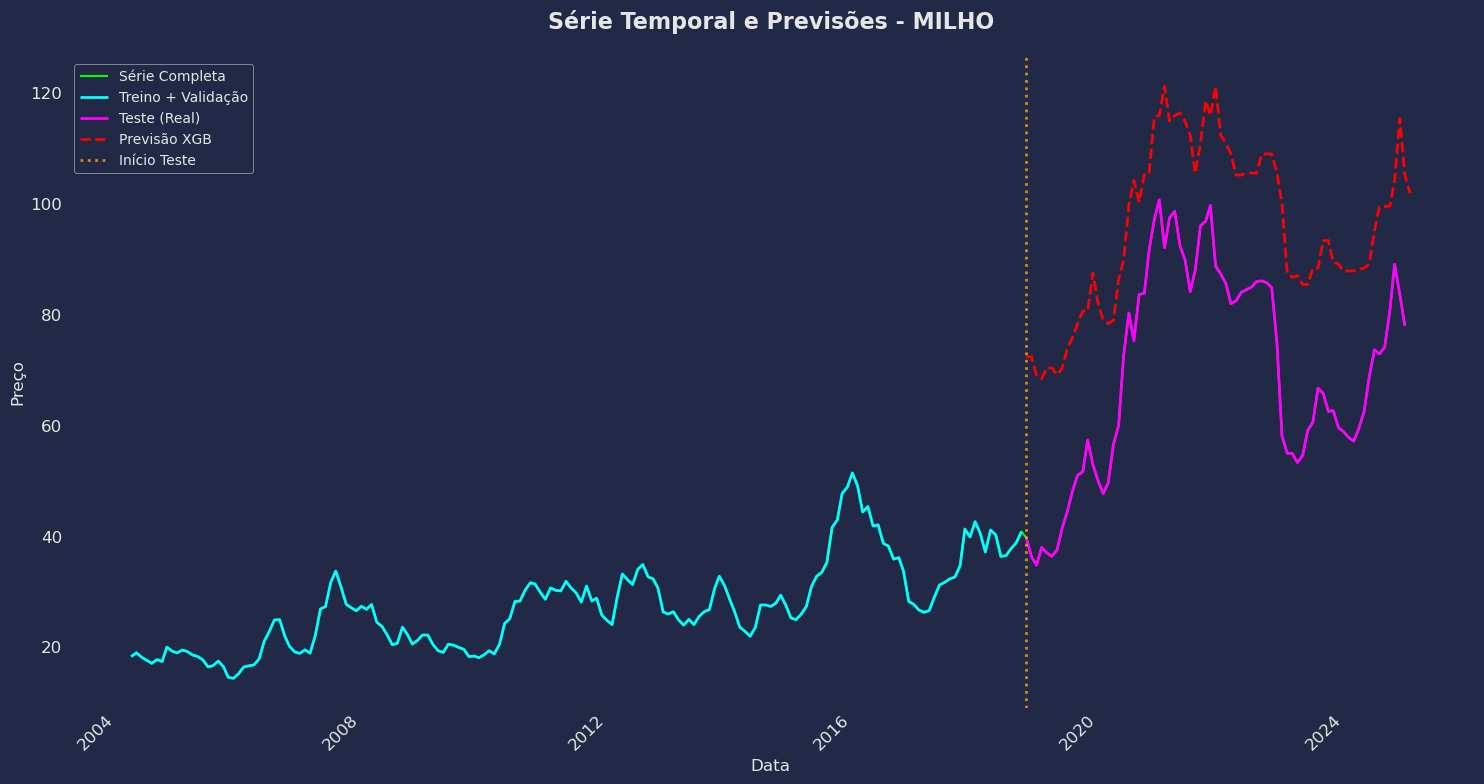

Gráfico exibido para: MILHO
--------------------------------------------------


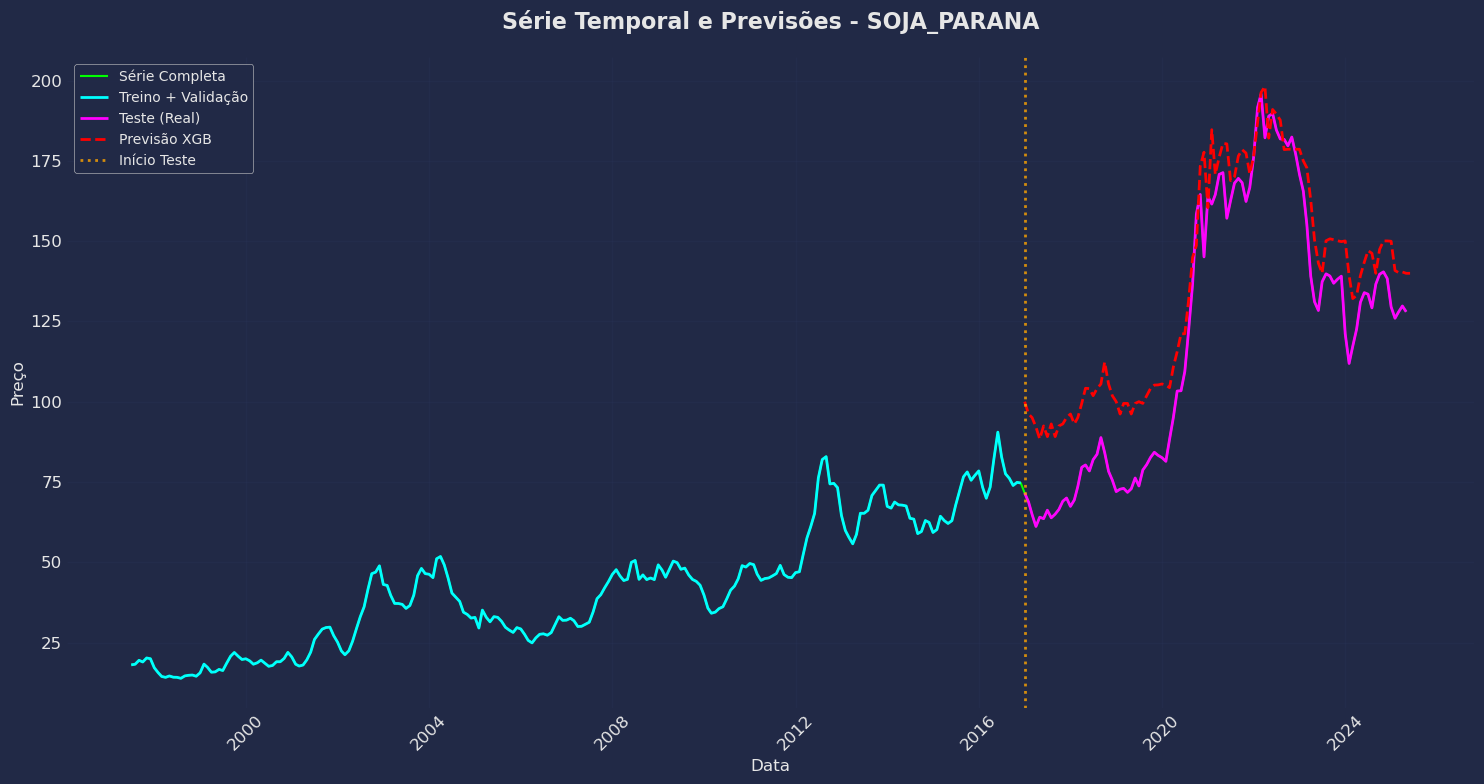

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


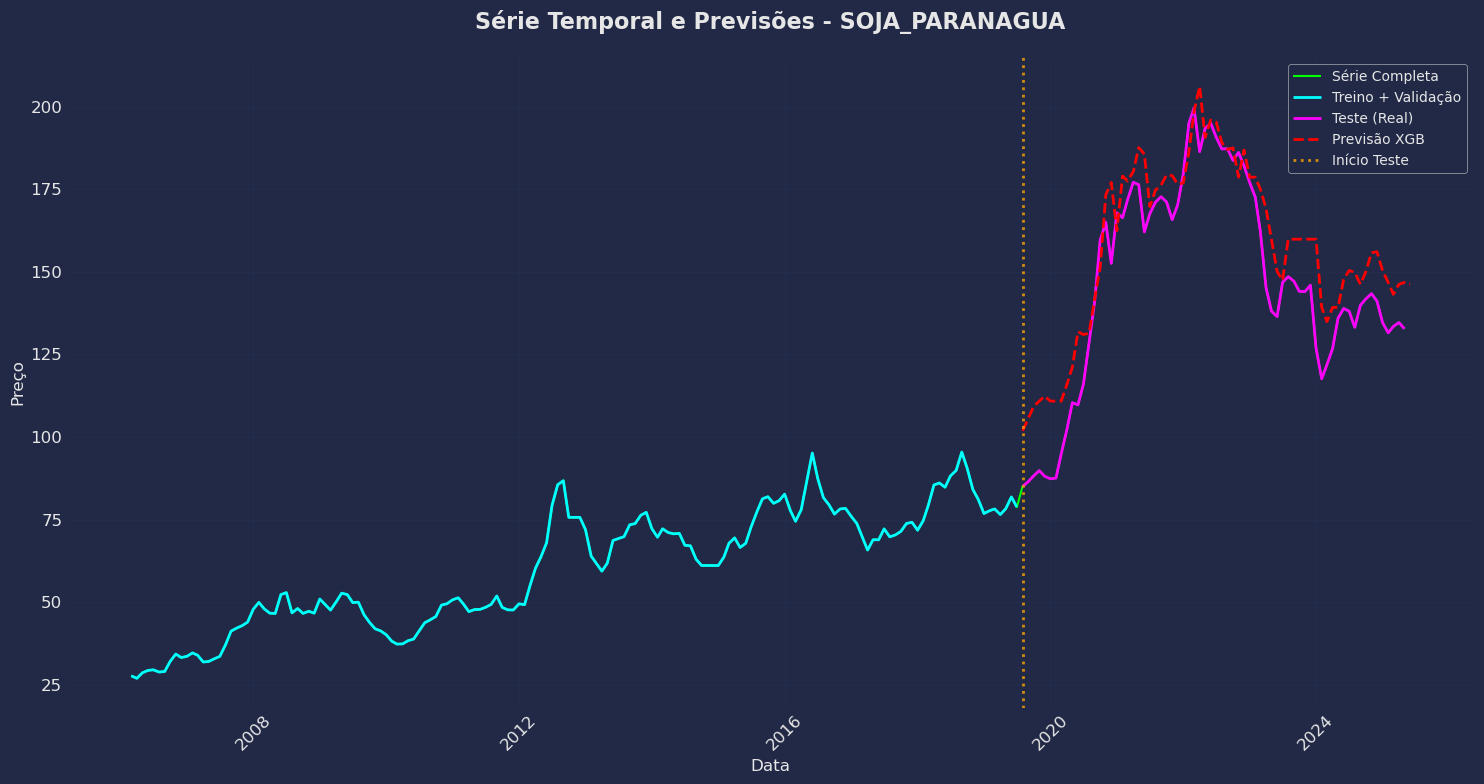

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


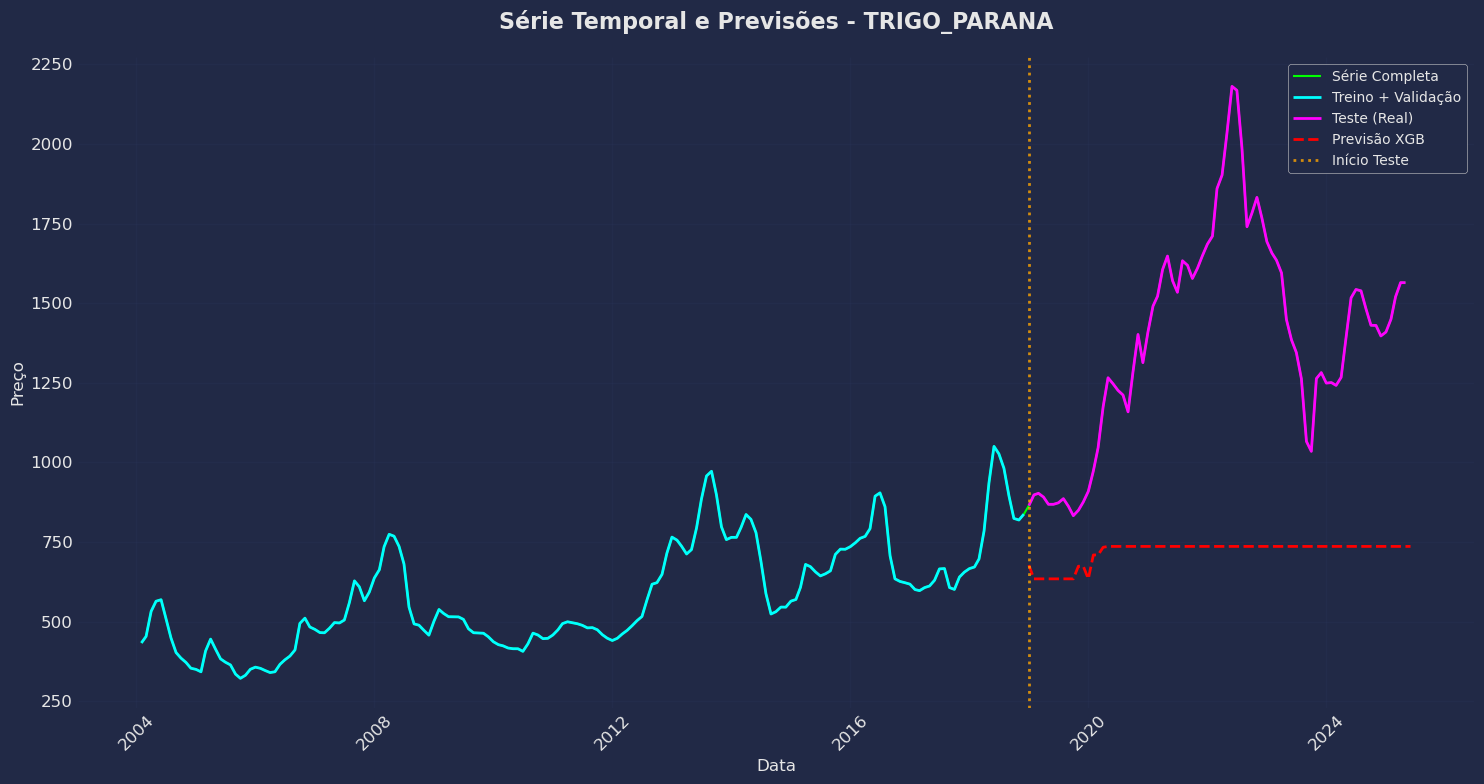

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


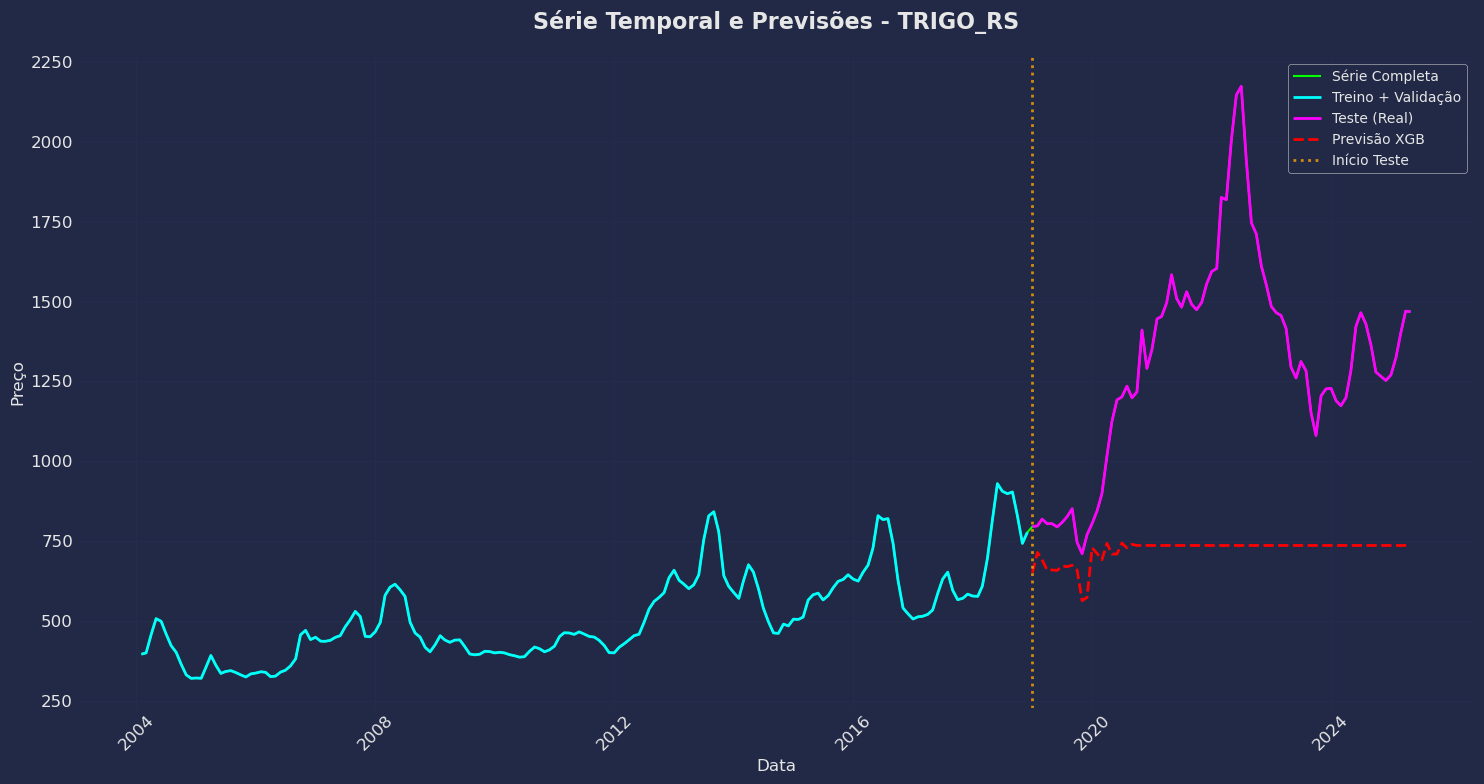

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [11]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['xgb'], 
                color='red', linewidth=2, linestyle='--', label='Previsão XGB')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

### Tunned

In [12]:
def mae_from_forecasts(forecasts_df, actual_df, model_col='xgb'):
    df = forecasts_df.merge(actual_df[['unique_id','ds','y']], 
                            on=['unique_id','ds'], how='inner')
    if len(df) == 0:
        return np.inf
    return mean_absolute_error(df['y'], df[model_col])

In [13]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_categorical("learning_rate", [0.5, 0.3, 0.25, 0.125, 0.0625, 0.03125, 0.1, 0.01, 0.05])
    reg_alpha = trial.suggest_categorical("reg_alpha", [0, 0.01, 0.5, 1, 5])
    reg_lambda = trial.suggest_categorical("reg_lambda", [0, 0.01, 0.5, 1, 5, 10])
    max_depth = trial.suggest_int("max_depth", 5, 10)
    min_split_loss = trial.suggest_int("min_split_loss", 0, 5)
    objective = trial.suggest_categorical("objective", ["reg:squarederror", "reg:absoluteerror", "reg:pseudohubererror", "reg:tweedie"])
    subsample = trial.suggest_categorical("subsample", [0.6, 0.8, 1.0])
    colsample_bytree = trial.suggest_categorical("colsample_bytree", [0.6, 0.8, 1.0])
    
    # modelo pipeline com MinMaxScaler
    model = make_pipeline(
        MinMaxScaler(feature_range=(0,1)),
        XGBRegressor(
            n_estimators=n_estimators, 
            learning_rate=learning_rate,
            reg_alpha=reg_alpha, 
            reg_lambda=reg_lambda,
            max_depth=max_depth, 
            objective=objective,
            subsample=subsample,
            min_split_loss=min_split_loss,
            colsample_bytree=colsample_bytree
        )
    )
    
    fcst = MLForecast(models={'xgb': model}, lags=lags, freq='MS')
    fcst.fit(train)
    
    preds = []
    for i in range(len(val)):
        f_next = fcst.predict(h=1)
        preds.append(f_next)
        obs = val.iloc[[i]][['unique_id','ds','y']]
        fcst.update(obs)
    
    forecasts_df = pd.concat(preds, ignore_index=True)
    mae = mae_from_forecasts(forecasts_df, val, model_col='xgb')
    
    return mae

# https://www.mdpi.com/2227-9091/11/2/27
# https://www.nature.com/articles/s41598-025-05103-z?fromPaywallRec=false#Sec15
# https://www.sciencedirect.com/science/article/abs/pii/S1568494619306180?via%3Dihub
# https://jutif.if.unsoed.ac.id/index.php/jurnal/article/view/4965/929

In [14]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

study.optimize(objective, n_trials=80, n_jobs=1)

print("Melhor score (val):", study.best_value)
print("Melhores hiperparâmetros:", study.best_params)

[I 2025-10-07 09:03:16,274] A new study created in memory with name: no-name-5b5a477b-0691-48ab-889c-1e260a73f514
[I 2025-10-07 09:03:37,732] Trial 0 finished with value: 48277.3470738819 and parameters: {'n_estimators': 218, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10, 'max_depth': 5, 'min_split_loss': 1, 'objective': 'reg:pseudohubererror', 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 0 with value: 48277.3470738819.
[I 2025-10-07 09:03:58,041] Trial 1 finished with value: 14.588588674726669 and parameters: {'n_estimators': 477, 'learning_rate': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5, 'max_depth': 8, 'min_split_loss': 5, 'objective': 'reg:tweedie', 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 1 with value: 14.588588674726669.
[I 2025-10-07 09:04:18,150] Trial 2 finished with value: 10.728015615205399 and parameters: {'n_estimators': 113, 'learning_rate': 0.25, 'reg_alpha': 5, 'reg_lambda': 10, 'max_depth': 8, 'min_split_loss': 5, 'objective': 'r

Melhor score (val): 6.534697802853571
Melhores hiperparâmetros: {'n_estimators': 332, 'learning_rate': 0.25, 'reg_alpha': 0.01, 'reg_lambda': 10, 'max_depth': 10, 'min_split_loss': 3, 'objective': 'reg:absoluteerror', 'subsample': 1.0, 'colsample_bytree': 0.6}


In [15]:
best = study.best_params
xgb_best = XGBRegressor(
            n_estimators=best['n_estimators'], 
            learning_rate=best['learning_rate'],
            reg_alpha=best['reg_alpha'], 
            reg_lambda=best['reg_lambda'],
            max_depth=best['max_depth'],
            objective=best['objective'],
            subsample=best['subsample'],
            min_split_loss=best['min_split_loss'],
            colsample_bytree=best['colsample_bytree']
        )
model_best = make_pipeline(MinMaxScaler(feature_range=(0,1)), xgb_best)

fcst_final = MLForecast(models={'xgb': model_best}, lags=lags, freq='MS')
fcst_final.fit(full_train)

MLForecast(models=[xgb], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [16]:
import os
import joblib

SAVE_DIR = "/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/"

# Garante que o diretório exista
os.makedirs(SAVE_DIR, exist_ok=True)

def save_model(model, name: str):
    """
    Salva modelos de sklearn, keras e pmdarima no formato adequado.

    Parâmetros:
    - model: objeto do modelo treinado
    - name: nome do arquivo (sem extensão)
    """
    path = os.path.join(SAVE_DIR, name)

    joblib.dump(model, f"{path}.pkl")
    print(f"✅ Modelo sklearn salvo em: {path}.pkl")

save_model(fcst_final, "xgb_tunned")

✅ Modelo sklearn salvo em: /home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/xgb_tunned.pkl


In [17]:
forecasts = []
for i in range(len(test)):
    f_next = fcst_final.predict(h=1)
    forecasts.append(f_next)
    obs = test.iloc[[i]][['unique_id','ds','y']]
    fcst_final.update(obs)

forecasts_df = pd.concat(forecasts, ignore_index=True)

In [18]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['xgb'],         
    groupby_column='unique_id'     
)
print(results)
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)

         unique_id Model  n_observations         MAE      MAPE           MSE  \
0    ACUCAR_SANTOS   xgb              20   10.605109  0.070611    169.368268   
1        ACUCAR_SP   xgb             100    6.157853  0.065372     58.151349   
2          ALGODAO   xgb             205   13.513251  0.035851    614.057617   
3            ARROZ   xgb             277    2.667954  0.040720     21.406227   
4     CAFE_ARABICA   xgb             381   84.716084  0.083929  58952.458746   
5     CAFE_ROBUSTA   xgb             468   52.994988  0.110930  18664.326599   
6            MILHO   xgb             543    1.585557  0.032869      5.378180   
7      SOJA_PARANA   xgb             644    1.111932  0.009916     12.009947   
8   SOJA_PARANAGUA   xgb             714    6.473341  0.073098     45.575256   
9     TRIGO_PARANA   xgb             791  134.147301  0.128061  47029.676922   
10        TRIGO_RS   xgb             868   67.232426  0.060145  29299.111680   

          RMSE        R2  
0    13.0141

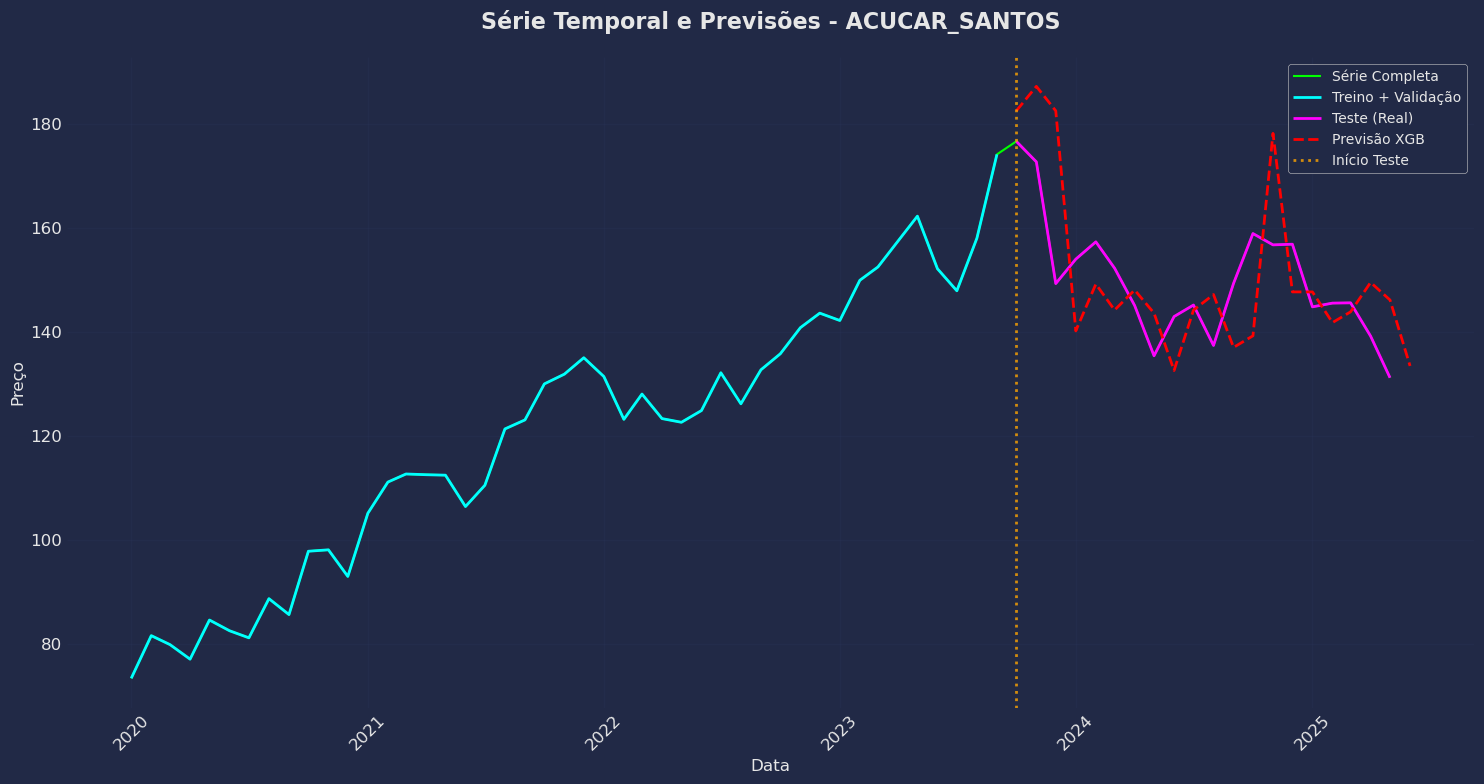

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


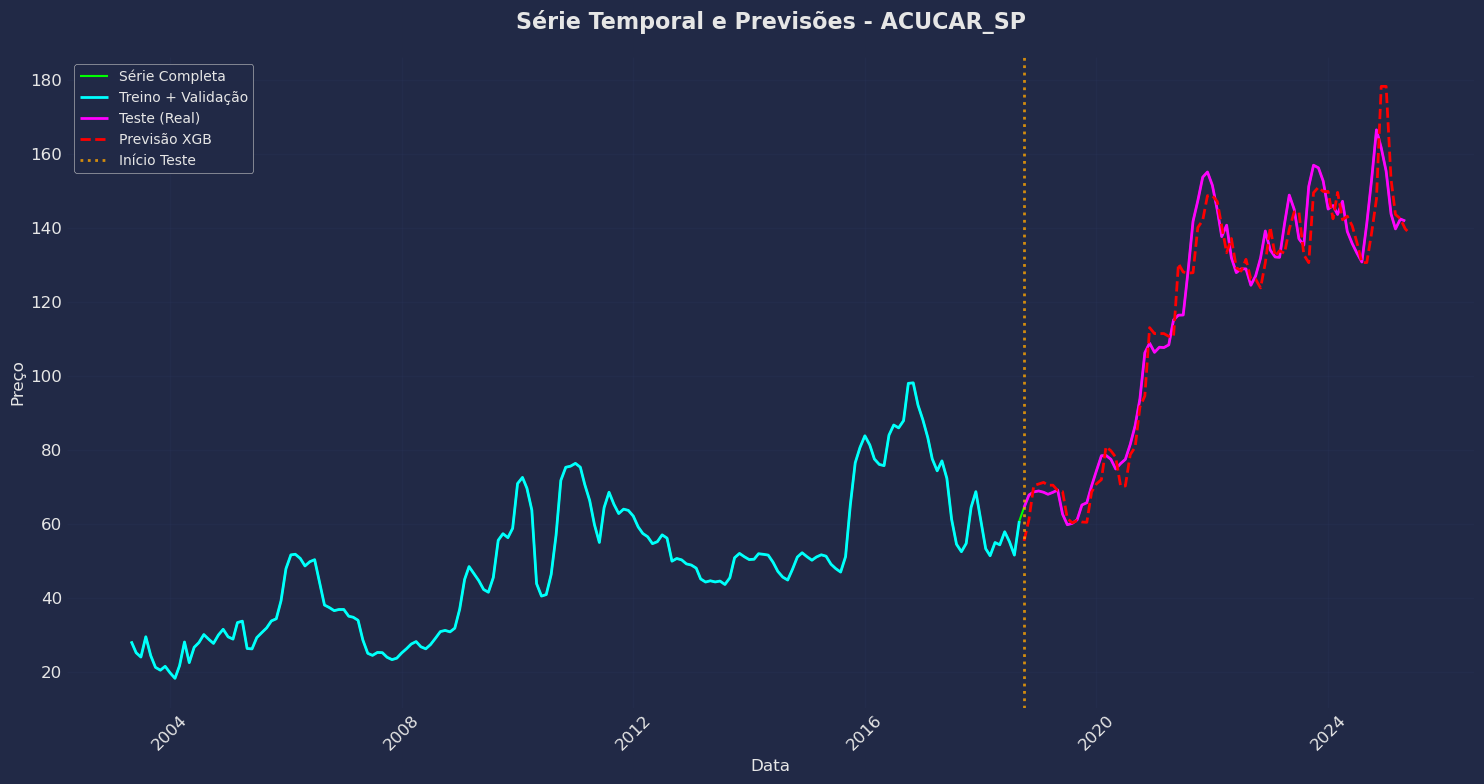

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


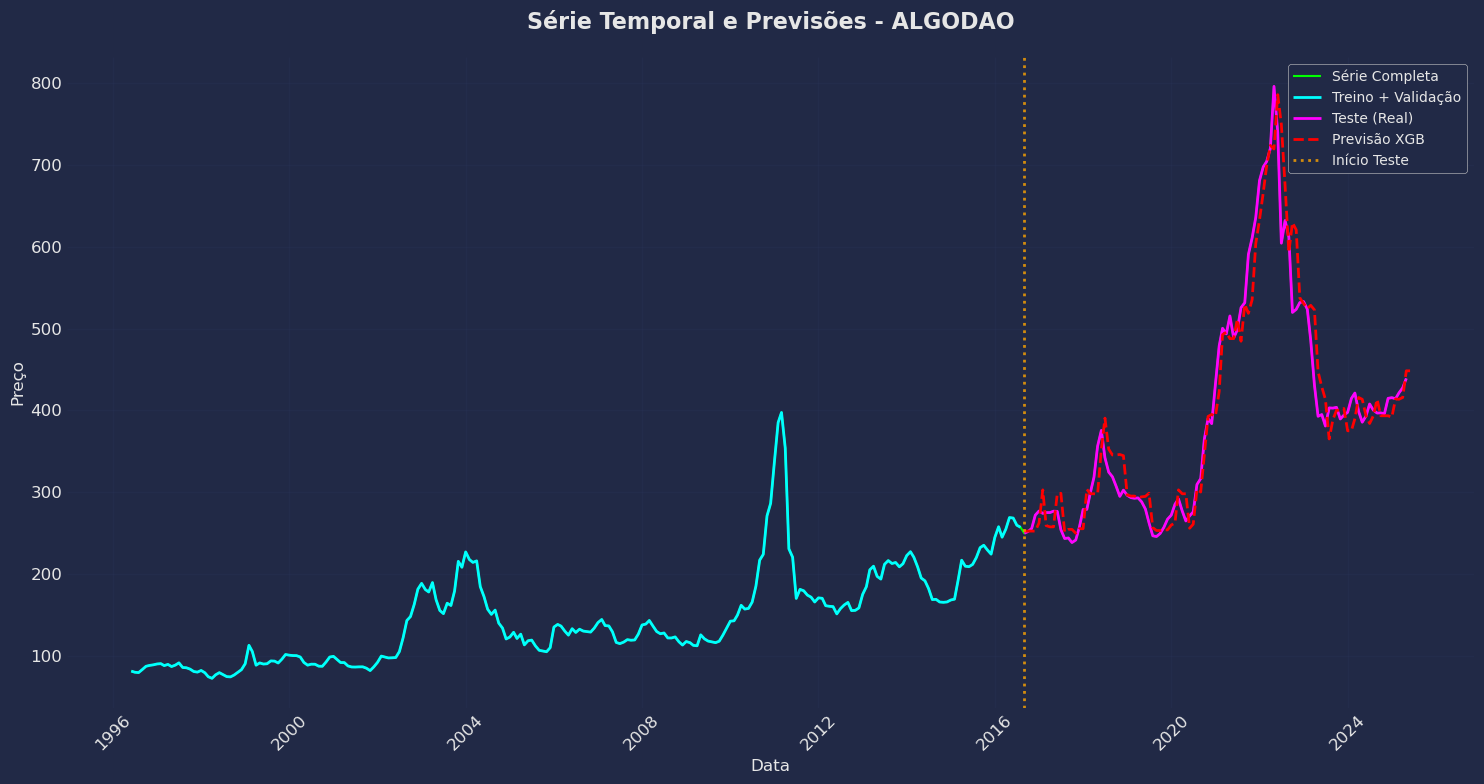

Gráfico exibido para: ALGODAO
--------------------------------------------------


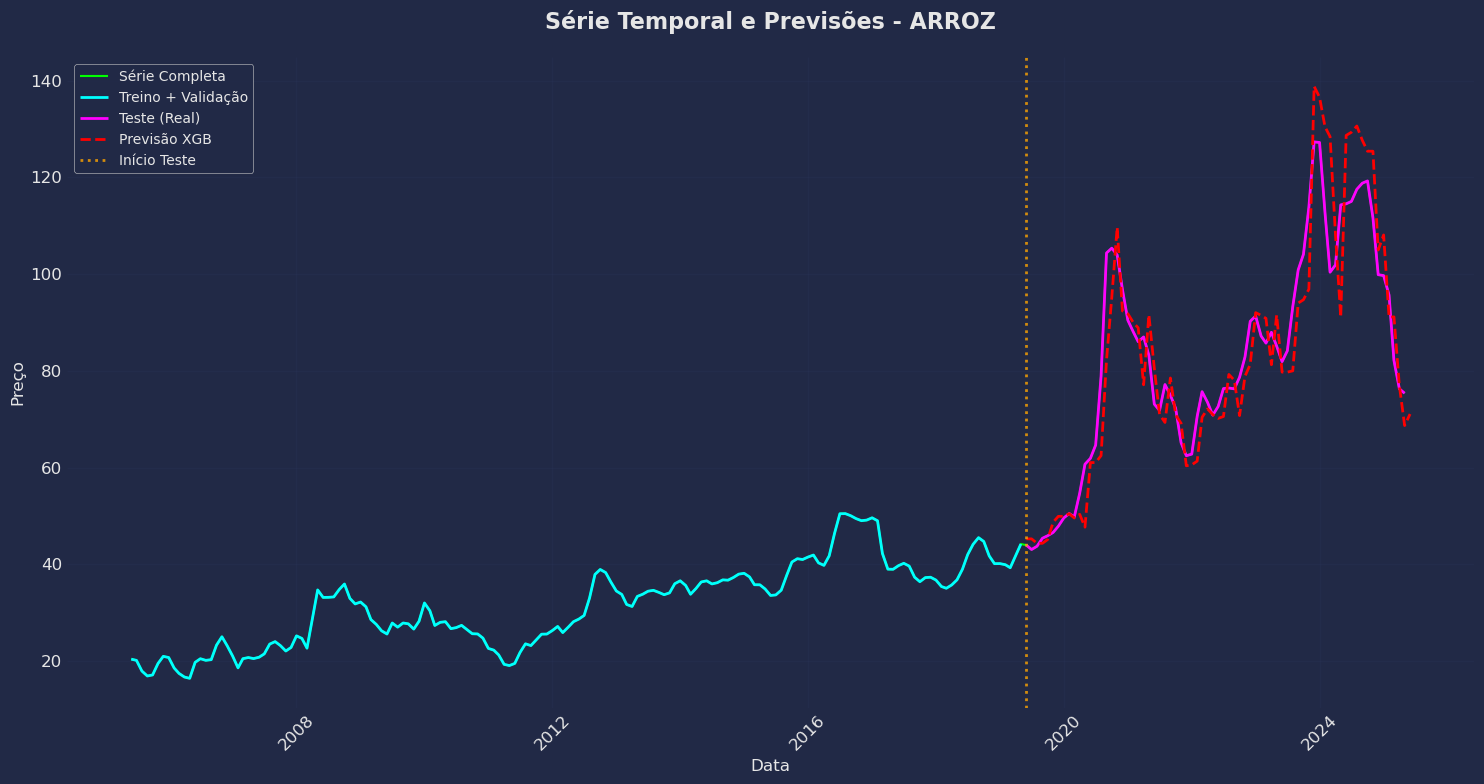

Gráfico exibido para: ARROZ
--------------------------------------------------


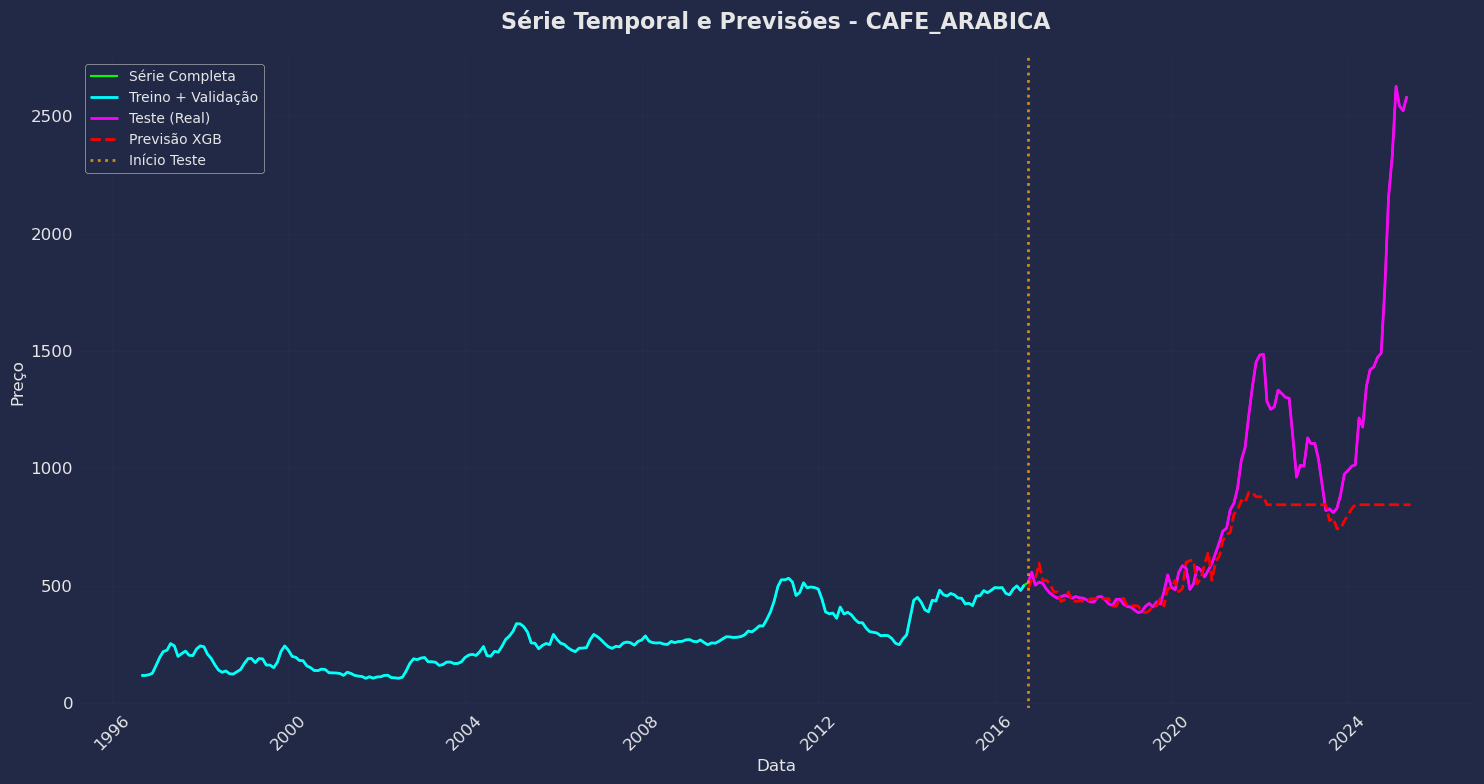

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


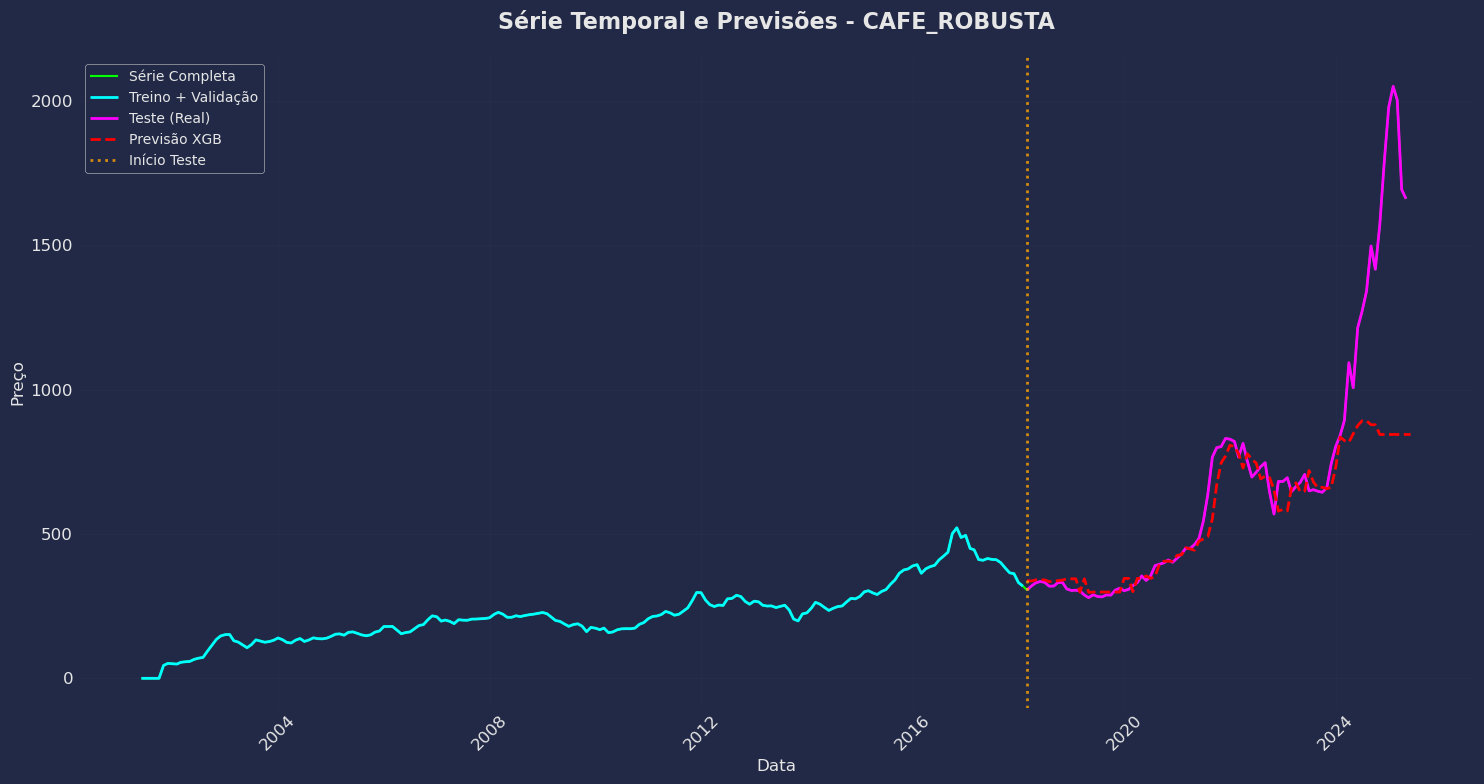

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


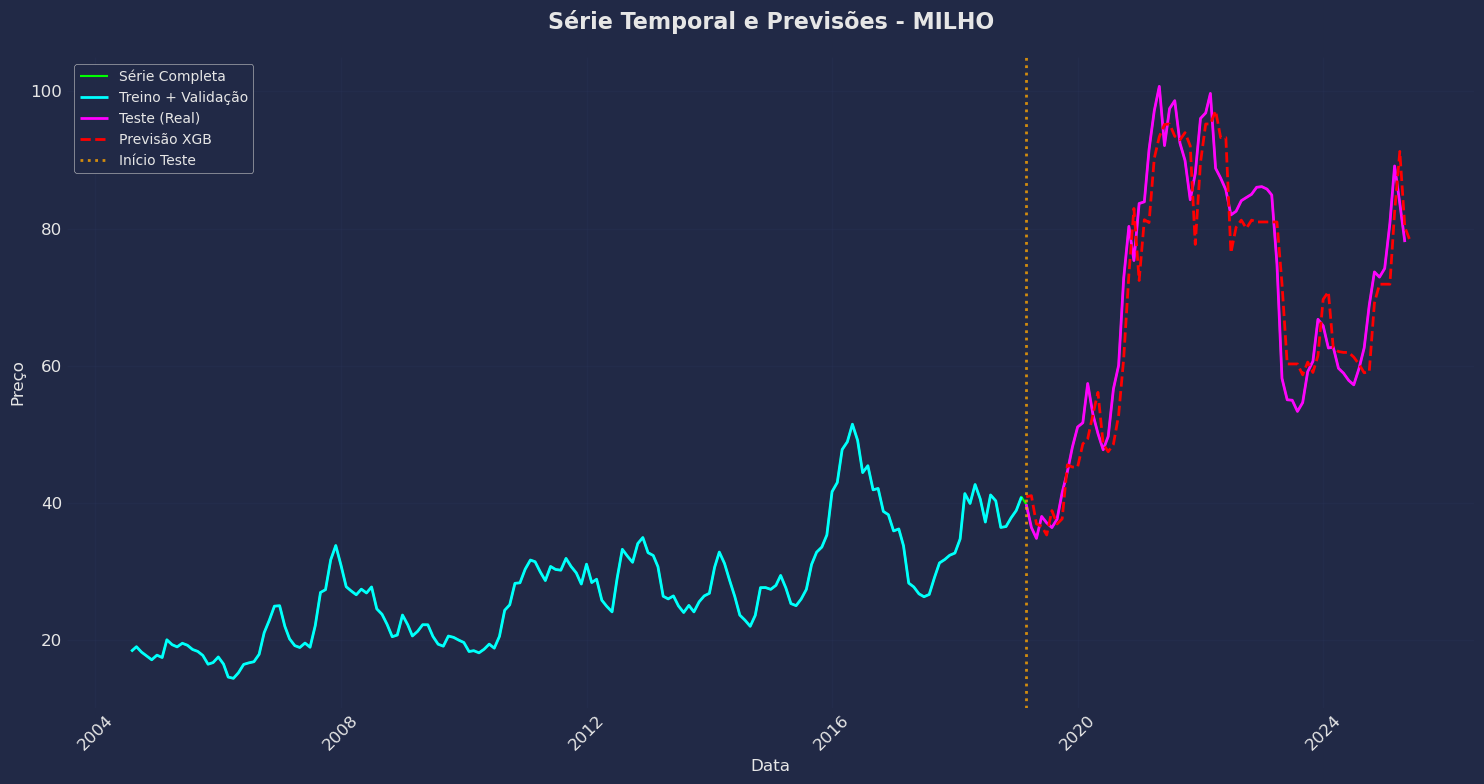

Gráfico exibido para: MILHO
--------------------------------------------------


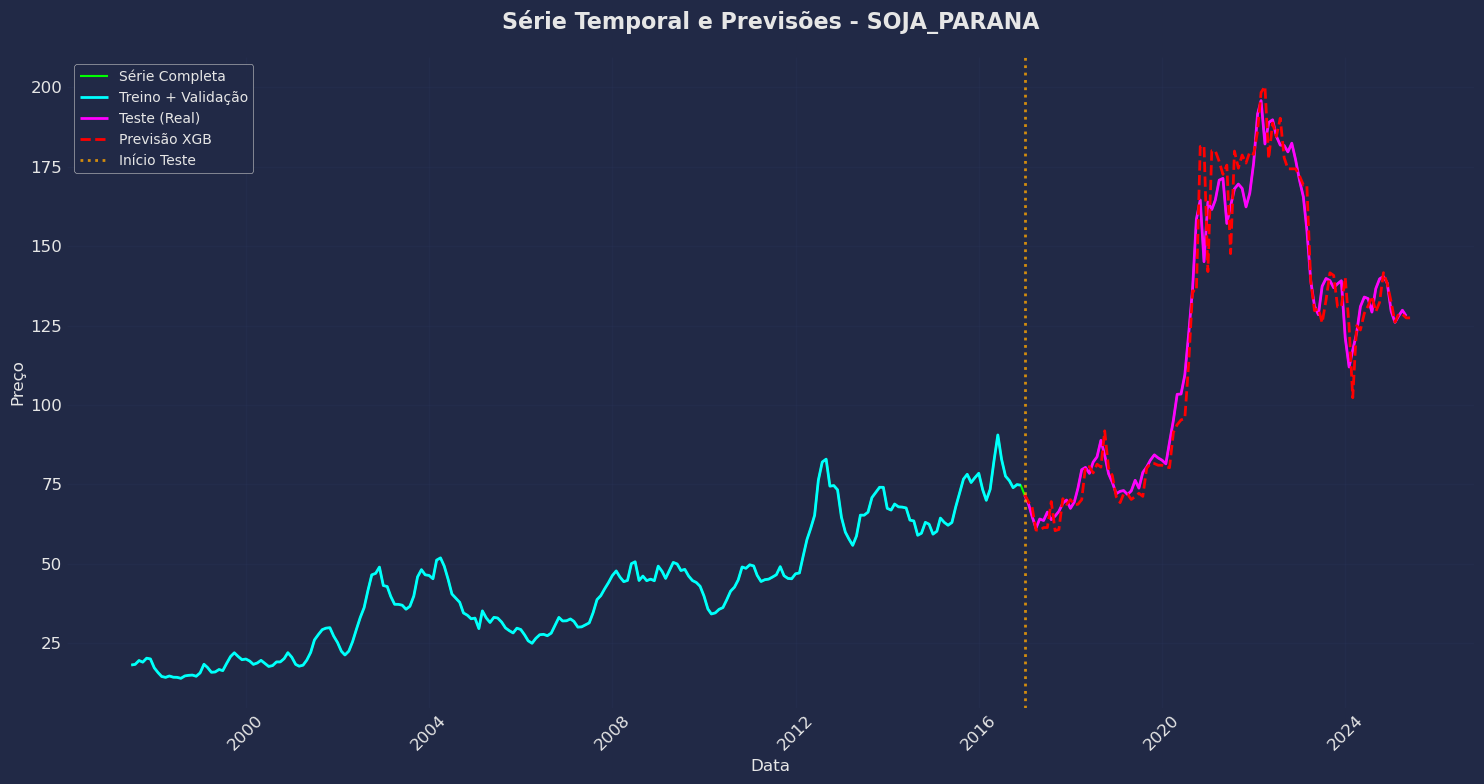

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


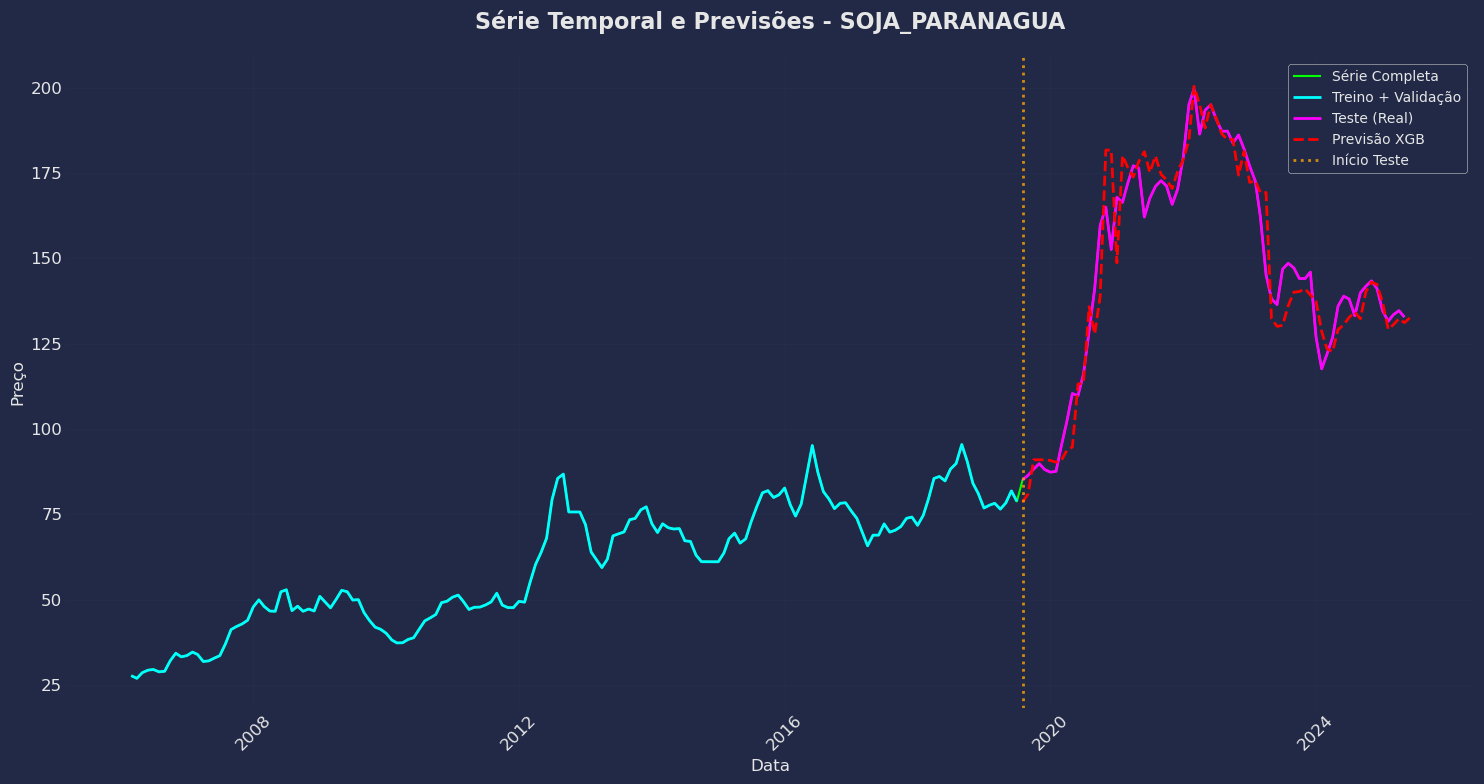

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


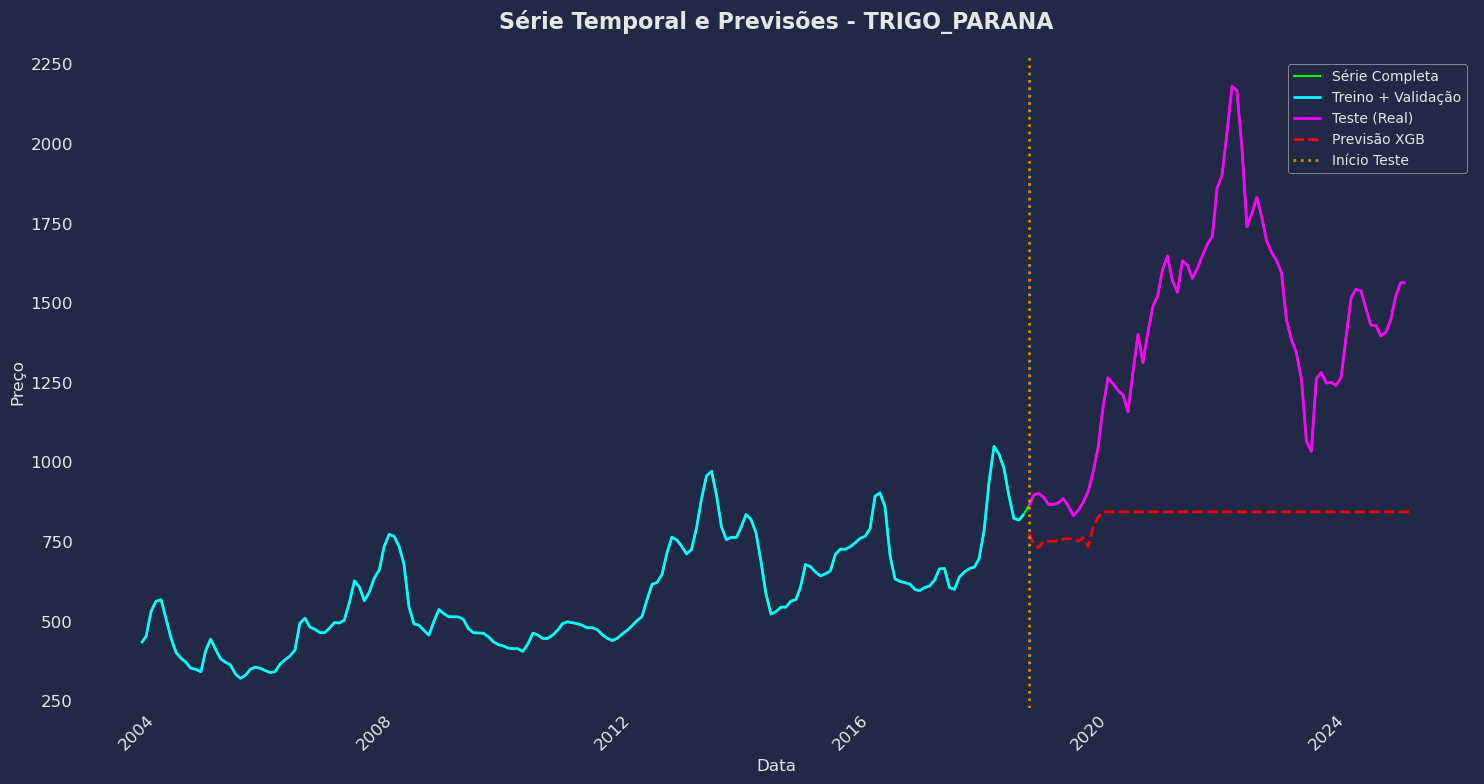

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


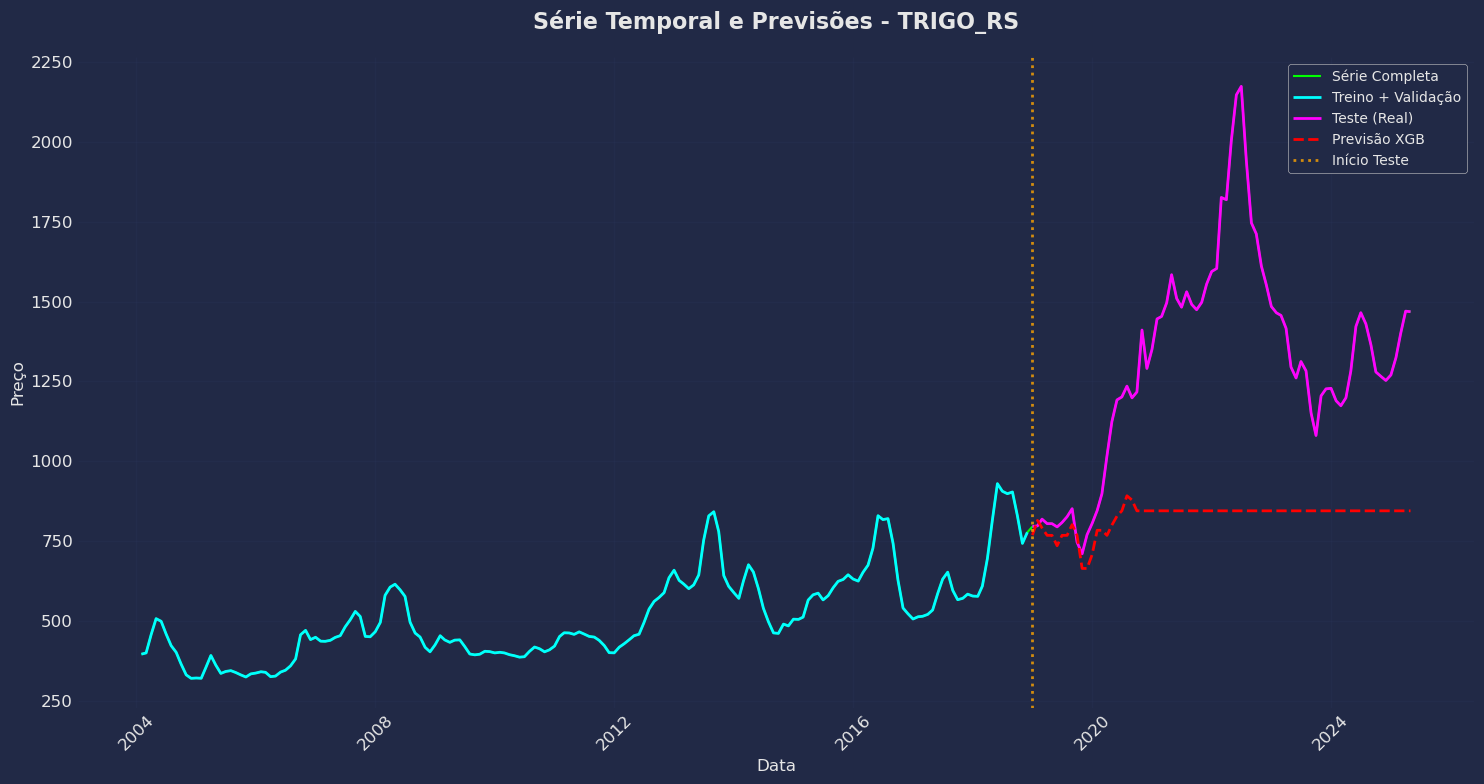

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [19]:
plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)